[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/SatelliteVu/SatelliteVu-AWS-Disaster-Response-Hackathon/blob/main/dataset_preparation/data-stats.ipynb)

Open all frames in the dataset, extract reqired statistics, used for standardising the data for the neural network

In [15]:
from tqdm import tqdm
import pandas as pd
import s3fs
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from multiprocessing.pool import ThreadPool 
import os

print(os.cpu_count())

8


In [16]:
def get_stats(img_arr: np.array) -> dict:
    """Return dict of image stats"""
    
    response = {}
    response.update({"min": float(np.min(img_arr))})
    response.update({"max": float(np.max(img_arr))})
    response.update({"sum": float(np.sum(img_arr))})
    response.update({"mean": float(np.mean(img_arr))})
    response.update({"standard_deviation": float(np.std(img_arr))})
    response.update({"0_1th_percentile": float(np.percentile(img_arr, 0.1))})
    # response.update({"1th_percentile": float(np.percentile(img_arr, 1))})
    # response.update({"5th_percentile": float(np.percentile(img_arr, 5))})
    # response.update({"25th_percentile": float(np.percentile(img_arr, 25))})
    # response.update({"75th_percentile": float(np.percentile(img_arr, 75))})
    # response.update({"95th_percentile": float(np.percentile(img_arr, 95))})
    # response.update({"99th_percentile": float(np.percentile(img_arr, 99))})
    response.update({"99_9th_percentile": float(np.percentile(img_arr, 99.9))})
    response.update({"nan_count": int(np.isnan(img_arr).sum())})
    return response

In [17]:
fs = s3fs.S3FileSystem()

Get features available from a single example

In [18]:
features = fs.glob('satvu-derived-data/hackathon_data/samples/0/*.npy')
features = [f.split('/')[-1].split('.')[0] for f in features]
features.remove('sea_surface_temperature')
features

['air_pressure_at_mean_sea_level',
 'air_temperature_at_2_metres',
 'air_temperature_at_2_metres_1hour_Maximum',
 'air_temperature_at_2_metres_1hour_Minimum',
 'dew_point_temperature_at_2_metres',
 'eastward_wind_at_100_metres',
 'eastward_wind_at_10_metres',
 'elevation',
 'integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation',
 'landcover',
 'lwe_thickness_of_surface_snow_amount',
 'ndvi',
 'northward_wind_at_100_metres',
 'northward_wind_at_10_metres',
 'precipitation_amount_1hour_Accumulation',
 'snow_density',
 'surface_air_pressure',
 'todays_fires',
 'todays_frp',
 'tomorrows_fires',
 'tomorrows_frp']

In [19]:
# or manually curate

features = [
    'todays_frp',
    'elevation',
    'landcover',
    'todays_fires',
    'tomorrows_fires',
]

Get the unique samples from James

In [20]:
# sample_ids = [9999] + [0] + [int(i) for i in str(fs.open('s3://satvu-derived-data/hackathon/james/tfrecords_updated_filtered/order.txt').read()).split(',')[1:-1]]
# sample_ids = sorted(sample_ids)
# print(len(sample_ids))
# sample_ids[:5]

splits_df = pd.read_csv('splits.csv')
sample_ids = splits_df['sample_id'].unique()
len(sample_ids)

15435

In [21]:
def get_data_for_sample(id: int) -> pd.DataFrame:
    try:
        feature_list = []
        for feature in features:
            url = f's3://satvu-derived-data/hackathon_data/samples/{id}/{feature}.npy'
            data = np.load(fs.open(url))
            img_dict = get_stats(data)
            img_dict['sample_id'] = int(id)
            img_dict['feature'] = feature
            # img_dict['url'] = url
            feature_list.append(pd.DataFrame(img_dict, index = [0]))
        return pd.concat(feature_list, axis=0, ignore_index=True)
    except Exception as e:
        print(f'Error processing sample {id}: {e}')
        return None

In [23]:
# get_data_for_sample('12586') # bad file
get_data_for_sample(0) # good file

,min,max,sum,mean,standard_deviation,0_1th_percentile,99_9th_percentile,nan_count,sample_id,feature
0,0.0,140.530000,698.45000,0.170520,3.435532,0.0,62.58000,0,0,todays_frp
1,0.0,77.406967,137668.78125,33.610542,18.203369,0.0,74.52055,0,0,elevation
2,10.0,90.000000,83080.00000,20.283203,18.497463,10.0,80.00000,0,0,landcover
3,0.0,1.000000,25.00000,0.006104,0.077886,0.0,1.00000,0,0,todays_fires
4,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0,0,tomorrows_fires


In [24]:
%%time
    
with ThreadPool(os.cpu_count()) as pool:
      results = list(tqdm(pool.imap(get_data_for_sample, sample_ids), total=len(sample_ids)))
    
len(results)

100%|██████████| 15435/15435 [26:39<00:00,  9.65it/s] 


CPU times: user 5min 31s, sys: 29.7 s, total: 6min
Wall time: 26min 40s


15435

In [25]:
df = pd.concat(results, axis=0)
df.to_csv('data_stats.csv', index=False)
df.shape

(77175, 10)

In [28]:
df.groupby('feature').mean().to_csv('data_stats_mean.csv', index=True)

In [27]:
df.groupby('feature').mean()

,min,max,sum,mean,standard_deviation,0_1th_percentile,99_9th_percentile,nan_count,sample_id
feature,,,,,,,,,
elevation,469.746265,1175.622036,3.123095e+06,762.474345,138.177659,478.390159,1139.643686,0.0,8844.249368
landcover,10.030450,94.451895,1.116076e+05,27.247959,21.845070,10.062627,92.402169,0.0,8844.249368
todays_fires,0.000000,0.999741,1.303353e+02,0.031818,0.157910,0.000000,0.999605,0.0,8844.249368
todays_frp,0.000000,166.831030,2.644683e+03,0.645608,6.045492,0.000000,88.271995,0.0,8844.249368
tomorrows_fires,0.000000,0.870230,9.705546e+01,0.023693,0.121255,0.000000,0.812485,0.0,8844.249368


In [69]:
df.head()

,min,max,sum,mean,standard_deviation,0_1th_percentile,1th_percentile,5th_percentile,25th_percentile,75th_percentile,95th_percentile,99th_percentile,99_9th_percentile,nan_count,sample_id,feature,url
0,250.517772,251.801893,1.028784e+06,251.168018,0.239222,250.541971,250.617991,250.791421,250.972532,251.344177,251.572947,251.702094,251.786031,0,0,air_temperature_at_2_metres_1hour_Minimum,s3://satvu-derived-data/hackathon_data/samples...
1,251.406216,252.367723,1.031216e+06,251.761629,0.203830,251.416025,251.443462,251.482532,251.578249,251.917226,252.115081,252.238278,252.334515,0,0,air_temperature_at_2_metres_1hour_Maximum,s3://satvu-derived-data/hackathon_data/samples...
2,0.000000,77.406967,1.376688e+05,33.610542,18.203369,0.000000,0.000000,3.015698,18.140119,48.049352,60.869523,68.323860,74.520550,0,0,elevation,s3://satvu-derived-data/hackathon_data/samples...
3,10.000000,90.000000,8.308000e+04,20.283203,18.497463,10.000000,10.000000,10.000000,10.000000,30.000000,80.000000,80.000000,80.000000,0,0,landcover,s3://satvu-derived-data/hackathon_data/samples...
4,-1.000000,0.998171,2.300642e+03,0.561680,0.253865,-1.000000,-0.828980,0.274783,0.534010,0.684211,0.778860,0.837608,0.997738,0,0,ndvi,s3://satvu-derived-data/hackathon_data/samples...


<AxesSubplot:>

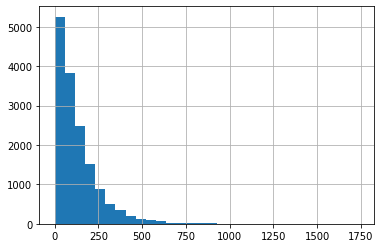

In [29]:
df[df['feature']=='todays_fires']['sum'].hist(bins=30)

In [30]:
df.groupby('feature').sum()['nan_count']

feature
elevation          0
landcover          0
todays_fires       0
todays_frp         0
tomorrows_fires    0
Name: nan_count, dtype: int64